# Assignment 1 

**Student Name:**  Michelle Fong

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1:  Text Classification

This part is to build a text classification predicting the class ComputationalLinguistics. There are variations of the model in the training process:  
1. Data input: Abstract vs Title
2. Algorithm: Statistic model vs RNN
3. Training size: Full training dataset vs frist 1000
cases

Therefore there are a total of 6 (2x2x2) models generated. The results are measured by using 4 metrics: F1, precision, recall and accuracy, and they were visualised in Part D. Further discussion would be held in the pdf report.

Because getting into the model building, the data was loaded and pre-processed. They were tokenized, using Regular Expression Tokenizer, lemmatized and stopwords have been removed.

## Import Lib

In [ ]:
#  import all libraries for part 1
%matplotlib inline
import pandas as pd
import numpy as np

# pre-processing
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# stat model
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve


In [ ]:
# RNN
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext import data
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn as nn
import math

# vis
import matplotlib.pyplot as plt

In [ ]:
# Loading datasets
df_dev = pd.read_csv('dev_set.csv')
df_test = pd.read_csv('test_set.csv')
df_train = pd.read_csv('train_set.csv')

# dimension
print(df_dev.shape)
print(df_test.shape)
print(df_train.shape)

(19073, 5)
(19074, 5)
(152586, 5)


In [ ]:
# For model training using cv
train = pd.concat([df_train,df_dev])

trainTitle = train.title.tolist()
trainAbs = train.abstract.tolist()
trainLabel = train.ComputationalLinguistics.tolist()

print(len(trainTitle), len(trainAbs), len(trainLabel))

171659 171659 171659


In [ ]:
trainAbs[5]

"  Cytology is a low-cost and non-invasive diagnostic procedure employed to\nsupport the diagnosis of a broad range of pathologies. Computer Vision\ntechnologies, by automatically generating quantitative and objective\ndescriptions of examinations' contents, can help minimize the chances of\nmisdiagnoses and shorten the time required for analysis. To identify the\nstate-of-art of computer vision techniques currently applied to cytology, we\nconducted a Systematic Literature Review. We analyzed papers published in the\nlast 5 years. The initial search was executed in September 2020 and resulted in\n431 articles. After applying the inclusion/exclusion criteria, 157 papers\nremained, which we analyzed to build a picture of the tendencies and problems\npresent in this research area, highlighting the computer vision methods,\nstaining techniques, evaluation metrics, and the availability of the used\ndatasets and computer code. As a result, we identified that the most used\nmethods in the an

## Preprocessing
After loading in the datasets, the data were preprocessed in this session. The textual data were tokenized using Regular Expression Tokenization to extract all words and then they were lammatized. As we only hope to keep meaningful tokens, the following tokens are removed: stopwords which has no sematic meaning, tokens with less than length of 1, numeric tokens. A function `preprocess_text` is defined to implement this process.


In [ ]:
# NLTK resources (stopwords and WordNet)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Initialize tokenizer, lemmatizer, and stop words
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# a function to implement preprocessing
def preprocess_text(text):
    # tokenize using regex
    tokens = tokenizer.tokenize(text.lower())

    # remove stop words, only no, one chr only word
    # and lemmatize the remaining tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words
              and not token.isnumeric() and len(token) > 1]
    return tokens


processed_text = preprocess_text(trainAbs[5])
print(processed_text)


['cytology', 'low', 'cost', 'non', 'invasive', 'diagnostic', 'procedure', 'employed', 'support', 'diagnosis', 'broad', 'range', 'pathology', 'computer', 'vision', 'technology', 'automatically', 'generating', 'quantitative', 'objective', 'description', 'examination', 'content', 'help', 'minimize', 'chance', 'misdiagnoses', 'shorten', 'time', 'required', 'analysis', 'identify', 'state', 'art', 'computer', 'vision', 'technique', 'currently', 'applied', 'cytology', 'conducted', 'systematic', 'literature', 'review', 'analyzed', 'paper', 'published', 'last', 'year', 'initial', 'search', 'executed', 'september', 'resulted', 'article', 'applying', 'inclusion', 'exclusion', 'criterion', 'paper', 'remained', 'analyzed', 'build', 'picture', 'tendency', 'problem', 'present', 'research', 'area', 'highlighting', 'computer', 'vision', 'method', 'staining', 'technique', 'evaluation', 'metric', 'availability', 'used', 'datasets', 'computer', 'code', 'result', 'identified', 'used', 'method', 'analyzed',

## Part 1A: Statistical Method

In this section, statistical model is used to build the text classifier, specifically Logistic Regression is used.ComputationalLinguistics has binary outcome so Logistic Regression is chosen.

Before parsing to the logistic model, the data input is vectorized using TFIDF. The vectorizer consider unigram, filter English stopwords and tokends with less than 20 occurance.

To avoid overfitting, 5-fold cross validation was implemented. The result are stored for comparison with RNN model.

#### Baseline Statistical Model
Below demostrates the baseline statisical model with pre-processing using abstract as an input and trained with the entire training dataset.

In [ ]:
# Top 10000 most freq words & min freq 20
# unigram
vectorizer = TfidfVectorizer(input='content',
                             stop_words='english',
                             lowercase=True,
                             token_pattern=r'\w+',
                             min_df=20,ngram_range=(1,1),
                             tokenizer=preprocess_text)

In [ ]:
random.seed(10)
# LogisticRegression with 5-fold of cross validation
model = LogisticRegression()
CV = 5  # number of folds

# to save evaluation results
entries = []

# tfidf of abstract
x_train = vectorizer.fit_transform(trainAbs)
y_train = np.asarray(trainLabel)

accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((fold_idx, accuracy))

cv_stat_base = pd.DataFrame(entries, columns=['fold_idx', 'accuracy'])
cv_stat_base

,fold_idx,accuracy
0,0,0.976261
1,1,0.975154
2,2,0.976116
3,3,0.974863
4,4,0.977047


In [ ]:
# pre-processing test data
testTitle = df_test.title.tolist()
testAbs = df_test.abstract.tolist()
testLabels = df_test.ComputationalLinguistics.tolist()

print(len(testTitle), len(testAbs), len(testLabels))

19074 19074 19074


In [ ]:
def metrics(y_test, y_prediction):
    # Calculate evaluation metrics
    cm = confusion_matrix(y_test, y_prediction)
    recall = round(recall_score(y_test, y_prediction, average='macro'), 2)
    precision = round(precision_score(y_test, y_prediction, average='macro'), 2)
    f1score = round(f1_score(y_test, y_prediction, average='macro'), 2)
    accuracy = round(accuracy_score(y_test, y_prediction), 2)
    matthews = round(matthews_corrcoef(y_test, y_prediction), 2)

    # Create a list of metrics
    metrics_list = [
        ('Accuracy', accuracy),
        ('Macro Precision', precision),
        ('Macro Recall', recall),
        ('Macro F1 score', f1score),
        ('MCC', matthews)
    ]

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Return list of metrics
    return metrics_list

In [ ]:
model = LogisticRegression()

x_test = vectorizer.transform(testAbs)
y_test = np.asarray(testLabels)

# train models
model.fit(x_train, y_train)

# Do the prediction
y_predict = model.predict(x_test)

stat_base = metrics(y_test, y_predict)
print(stat_base)

stat_base_precision, stat_base_recall,_ = precision_recall_curve(y_test, model.predict_proba(x_test)[:, 1])

Confusion Matrix:
[[13883   185]
 [  272  4734]]
[('Accuracy', 0.98), ('Macro Precision', 0.97), ('Macro Recall', 0.97), ('Macro F1 score', 0.97), ('MCC', 0.94)]


#### Statistical Model with different configuration

In this part, models are trained using the same statistical model (ie Logistic Regression) but with a different configurations. 2 different models are built for below changes
1. Input: Using Title only
2. Data size: Using first 1000 cases in training set

##### Using Title only
Below demostrates one of the variation of statisical model using Title as an input and trained with the entire training dataset.

In [ ]:
# pre-processing
# tfidf of title
x_train_title = vectorizer.fit_transform(trainTitle)
x_test_title = vectorizer.transform(testTitle)

random.seed(101)
# LogisticRegression with 5-fold of cross validation
model = LogisticRegression()
CV = 5  # number of folds

entries = []

accuracies = cross_val_score(model, x_train_title, y_train, scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['fold_idx', 'accuracy'])


# Train models
model.fit(x_train_title, y_train)

# Do the prediction
y_predict=model.predict(x_test_title)

stat_title = metrics(y_test, y_predict)
print(stat_title)


stat_title_precision, stat_title_recall,_ = precision_recall_curve(y_test, model.predict_proba(x_test_title)[:, 1])


Confusion Matrix:
[[13742   326]
 [  596  4410]]
[('Accuracy', 0.95), ('Macro Precision', 0.94), ('Macro Recall', 0.93), ('Macro F1 score', 0.94), ('MCC', 0.87)]


##### Using First 1000 Training Data
Below demostrates one vatiation of the statisical model using abstract as an input and trained with the first 1000 records in training dataset.

In [ ]:
x_train[:1000].shape

(1000, 14843)

In [ ]:
random.seed(101)
# LogisticRegression with 5-fold of cross validation
model = LogisticRegression()
CV = 5  # number of folds

entries = []

accuracies = cross_val_score(model, x_train[:1000], y_train[:1000], scoring='accuracy', cv=CV)
for fold_idx, accuracy in enumerate(accuracies):
    entries.append((fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['fold_idx', 'accuracy'])


# Train models
model.fit(x_train[:1000], y_train[:1000])

# Do the prediction
y_predict=model.predict(x_test[:1000])
stat_train = metrics(y_test[:1000], y_predict)
print(stat_train)

stat_train_precision, stat_train_recall,_ = precision_recall_curve(y_test[:1000], model.predict_proba(x_test[:1000])[:, 1])

Confusion Matrix:
[[730   2]
 [139 129]]
[('Accuracy', 0.86), ('Macro Precision', 0.91), ('Macro Recall', 0.74), ('Macro F1 score', 0.78), ('MCC', 0.63)]


## Part 1B: RNN Method

In this part, Recurrent Neural Network (RNN) is used to train the model with PyTorch.

The text data was splitted into batch and was tokenized to construct a vocabulary list including unkown token with a maxium of 10000 and tokens with less than 20 occurance are removed. This limits the dimension and parameter.

Then batches of data were parsed throught the model and optimized using SGD to minimize loss. The model is trained with a fixed number of epoches, and the best performing mdoel with the smallest loss is saved.



#### Baseline
This part demostrates the baseline RNN model using Abstract columns of all training dataset as an input.

In [ ]:
# Initialize tokenizer, lemmatizer, and stop words
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to perform lemmatization and stop word removal
def preprocess_text(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text.lower())

    # remove stop words, only no, one chr only word
    # and lemmatize the remaining tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words
              and not token.isnumeric() and len(token) > 1]
    return tokens

In [ ]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        # yield processed token
        # lower text, tokenize, lammetize, remove stopwods & len<3 & numeric text
        processed_text = preprocess_text(text)
        yield processed_text

# Data processing
def text_pipeline(x):
    return vocab(preprocess_text(x))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    return torch.tensor(label_list, dtype=torch.int64).to(device), pad_sequence(text_list, padding_value=vocab["<unk>"]).to(device)


class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# Extract relevant information and create list of tuples
data_train = []
for index, row in df_train.iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    abstract = row['abstract']
    data_train.append((computational_linguistics, abstract))

data_test = []
for index, row in df_test.iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    abstract = row['abstract']
    data_test.append((computational_linguistics, abstract))

data_dev = []
for index, row in df_dev.iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    abstract = row['abstract']
    data_dev.append((computational_linguistics, abstract))

In [ ]:
# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(data_train),
                                  specials=["<unk>"],
                                  min_freq = 20)
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# Print the first 10 words in the vocabulary
print("Vocabulary Sample:", list(vocab.get_itos())[:10])

# Extract unique labels from the training data
unique_labels = set(label for label, _ in data_train)
print("Unique Labels:", unique_labels)

vocab_size = len(list(vocab.get_itos()))
print(f"Unique tokens in TEXT vocabulary: {vocab_size}")
print(f"Unique tokens in LABEL vocabulary: {len(unique_labels)}")


Vocabulary Sample: ['<unk>', 'model', 'image', 'method', 'based', 'data', 'network', 'task', 'learning', 'performance']
Unique Labels: {0, 1}
Unique tokens in TEXT vocabulary: 17070
Unique tokens in LABEL vocabulary: 2


In [ ]:
train_dataset = TextDataset(data_train)
test_dataset = TextDataset(data_test)
validation_dataset = TextDataset(data_dev)

# Print the first sample from the train dataset
first_sample = next(iter(train_dataset))
print(first_sample)

(0, '  Reinforcement learning algorithms rely on carefully engineering environment\nrewards that are extrinsic to the agent. However, annotating each environment\nwith hand-designed, dense rewards is not scalable, motivating the need for\ndeveloping reward functions that are intrinsic to the agent. Curiosity is a\ntype of intrinsic reward function which uses prediction error as reward signal.\nIn this paper: (a) We perform the first large-scale study of purely\ncuriosity-driven learning, i.e. without any extrinsic rewards, across 54\nstandard benchmark environments, including the Atari game suite. Our results\nshow surprisingly good performance, and a high degree of alignment between the\nintrinsic curiosity objective and the hand-designed extrinsic rewards of many\ngame environments. (b) We investigate the effect of using different feature\nspaces for computing prediction error and show that random features are\nsufficient for many popular RL game benchmarks, but learned features appe

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
    # batch size = number of sample to be fit in the model (gpu size limit)

In [ ]:
# model
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):

        super().__init__()

        # token id to embedding
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):

        #text = [sent len, batch size]

        embedded = self.embedding(text)

        #embedded = [sent len, batch size, emb dim]

        output, hidden = self.rnn(embedded)

        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))

In [ ]:
num_categories = len(unique_labels)
embedding_dim = int(75.6496 * math.log(num_categories + 176.623) - 41.4457)
print("Embedding size :", embedding_dim)

Embedding size : 350


In [ ]:
INPUT_DIM = vocab_size
EMBEDDING_DIM = 350
HIDDEN_DIM = 250
OUTPUT_DIM = 1

rnn_base = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(rnn_base):,} trainable parameters')

The model has 1,619,351 trainable parameters


In [ ]:
optimizer = optim.SGD(rnn_base.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_base = rnn_base.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def train(model, dataloader, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for labels, texts in dataloader:
        labels = labels.to(device)
        texts = texts.to(device)
        # clear buf
        optimizer.zero_grad()

        # forwerd prop
        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels.float())

        acc = binary_accuracy(predictions, labels)

        # find grad
        loss.backward()
        # update param with cal grad
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for labels, texts in dataloader:
            labels = labels.to(device)
            texts = texts.to(device)

            predictions = model(texts).squeeze(1)

            loss = criterion(predictions, labels.float())

            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

import time

#runtime
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(rnn_base, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn_base, validation_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn_base.state_dict(), 'RNN_model_base.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 12s
	Train Loss: 0.589 | Train Acc: 72.39%
	 Val. Loss: 0.585 |  Val. Acc: 72.88%
Epoch: 02 | Epoch Time: 2m 8s
	Train Loss: 0.588 | Train Acc: 72.61%
	 Val. Loss: 0.584 |  Val. Acc: 73.04%
Epoch: 03 | Epoch Time: 2m 9s
	Train Loss: 0.587 | Train Acc: 72.76%
	 Val. Loss: 0.585 |  Val. Acc: 73.13%
Epoch: 04 | Epoch Time: 2m 8s
	Train Loss: 0.586 | Train Acc: 72.85%
	 Val. Loss: 0.583 |  Val. Acc: 73.22%
Epoch: 05 | Epoch Time: 2m 9s
	Train Loss: 0.586 | Train Acc: 72.90%
	 Val. Loss: 0.582 |  Val. Acc: 73.27%


In [ ]:
rnn_base.load_state_dict(torch.load('RNN_model_base.pt'))

<All keys matched successfully>

In [ ]:
y_predict = []
y_test = []

rnn_base.eval()
with torch.no_grad():
    for labels, texts in test_dataloader:
        predictions = rnn_base(texts).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict += rounded_preds.tolist()
        y_test += labels.tolist()
        #acc = binary_accuracy(predictions, batch.label)

y_predict = np.asarray(y_predict)
y_test = np.asarray(y_test)

rnn_base_precision, rnn_base_recall, _ = precision_recall_curve(y_test, y_predict)

In [ ]:
def metrics(y_test, y_prediction):
    # Calculate evaluation metrics
    cm = confusion_matrix(y_test, y_prediction)
    recall = round(recall_score(y_test, y_prediction, average='macro'), 2)
    precision = round(precision_score(y_test, y_prediction, average='macro'), 2)
    f1score = round(f1_score(y_test, y_prediction, average='macro'), 2)
    accuracy = round(accuracy_score(y_test, y_prediction), 2)
    matthews = round(matthews_corrcoef(y_test, y_prediction), 2)

    # Create a list of metrics
    metrics_list = [
        ('Accuracy', accuracy),
        ('Macro Precision', precision),
        ('Macro Recall', recall),
        ('Macro F1 score', f1score),
        ('MCC', matthews)
    ]

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Return list of metrics
    return metrics_list

In [ ]:
rnn_base_stat=metrics(y_test,y_predict)

Confusion Matrix:
[[14054    14]
 [ 5005     1]]


#### Title only
This part demostrates one variation of the RNN model using Title columns of all training dataset as an input.

In [ ]:
# Extract relevant information and create list of tuples
data_train = []
for index, row in df_train.iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    title = row['title']
    data_train.append((computational_linguistics, title))

data_test = []
for index, row in df_test.iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    title = row['title']
    data_test.append((computational_linguistics, title))

data_dev = []
for index, row in df_dev.iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    title = row['title']
    data_dev.append((computational_linguistics, title))

In [ ]:
print(data_train[:2])
print(len(data_train))

[(0, 'Large-Scale Study of Curiosity-Driven Learning'), (0, 'Entanglement-assisted quantum error-correcting codes over arbitrary\n  finite fields')]
152586


In [ ]:
# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(data_train),
                                  specials=["<unk>"],
                                  min_freq = 20,
                                  max_tokens=10000)
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# Print the first 10 words in the vocabulary
print("Vocabulary Sample:", list(vocab.get_itos())[:10])

# Extract unique labels from the training data
unique_labels = set(label for label, _ in data_train)
print("Unique Labels:", unique_labels)

vocab_size = len(list(vocab.get_itos()))
print(f"Unique tokens in TEXT vocabulary: {vocab_size}")
print(f"Unique tokens in LABEL vocabulary: {len(unique_labels)}")


Vocabulary Sample: ['<unk>', 'learning', 'image', 'network', 'model', 'based', 'using', 'language', 'detection', 'deep']
Unique Labels: {0, 1}
Unique tokens in TEXT vocabulary: 4196
Unique tokens in LABEL vocabulary: 2


In [ ]:
train_dataset = TextDataset(data_train)
test_dataset = TextDataset(data_test)
validation_dataset = TextDataset(data_dev)
# Print the first sample from the train dataset
first_sample = next(iter(train_dataset))
print(first_sample)

(0, 'Large-Scale Study of Curiosity-Driven Learning')


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=32,
                             shuffle=False, collate_fn=collate_batch)
validation_dataloader = DataLoader(validation_dataset, batch_size=32,
                                   shuffle=False, collate_fn=collate_batch)
    # batch size = number of sample to be fit in the model (gpu size limit)

In [ ]:
INPUT_DIM = vocab_size
EMBEDDING_DIM = 350
HIDDEN_DIM = 250
OUTPUT_DIM = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rnn_title = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.SGD(rnn_title.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss().to(device)


In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(rnn_title, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn_title, validation_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn_title.state_dict(), 'RNN_model_title.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.590 | Train Acc: 72.06%
	 Val. Loss: 0.583 |  Val. Acc: 72.85%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 0.587 | Train Acc: 72.53%
	 Val. Loss: 0.580 |  Val. Acc: 73.08%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.584 | Train Acc: 72.75%
	 Val. Loss: 0.576 |  Val. Acc: 73.27%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.576 | Train Acc: 72.89%
	 Val. Loss: 0.550 |  Val. Acc: 73.57%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.421 | Train Acc: 81.23%
	 Val. Loss: 0.333 |  Val. Acc: 86.11%


In [ ]:
rnn_title.load_state_dict(torch.load('RNN_model_title.pt'))

<All keys matched successfully>

In [ ]:
y_predict = []
y_test = []

rnn_title.eval()
with torch.no_grad():
    for labels, texts in test_dataloader:
        predictions = rnn_title(texts).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict += rounded_preds.tolist()
        y_test += labels.tolist()
        #acc = binary_accuracy(predictions, batch.label)

y_predict = np.asarray(y_predict)
y_test = np.asarray(y_test)
rnn_base_title=metrics(y_test,y_predict)

rnn_title_precision, rnn_title_recall, _ = precision_recall_curve(y_test, y_predict)

Confusion Matrix:
[[12951  1117]
 [ 1493  3513]]


In [ ]:
print(len(y_predict))
print(len(y_test))

19074
19074


In [ ]:
print(len(rnn_title_precision))
print(len(rnn_title_recall))

3
3


In [ ]:
print(np.unique(y_predict))

[0. 1.]


In [ ]:
rnn_title_precision, rnn_title_recall

(array([0.2624515, 0.7587473, 1.       ]),
 array([1.        , 0.70175789, 0.        ]))

#### First 1000 data
This part demostrates one variation of the RNN model using Abstract columns of the first 1000 records of the training dataset as an input.

In [ ]:
data_train = []
for index, row in df_train.head(1000).iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    abstract = row['abstract']
    data_train.append((computational_linguistics, abstract))

data_test = []
for index, row in df_test.head(1000).iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    abstract = row['abstract']
    data_test.append((computational_linguistics, abstract))

data_dev = []
for index, row in df_dev.head(1000).iterrows():
    computational_linguistics = row['ComputationalLinguistics']
    abstract = row['abstract']
    data_dev.append((computational_linguistics, abstract))

In [ ]:
# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(data_train),
                                  specials=["<unk>"],
                                  min_freq = 20)
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# Print the first 10 words in the vocabulary
print("Vocabulary Sample:", list(vocab.get_itos())[:10])

# Extract unique labels from the training data
unique_labels = set(label for label, _ in data_train)
print("Unique Labels:", unique_labels)

vocab_size = len(list(vocab.get_itos()))
print(f"Unique tokens in TEXT vocabulary: {vocab_size}")
print(f"Unique tokens in LABEL vocabulary: {len(unique_labels)}")


Vocabulary Sample: ['<unk>', 'model', 'image', 'method', 'based', 'task', 'data', 'network', 'learning', 'approach']
Unique Labels: {0, 1}
Unique tokens in TEXT vocabulary: 1105
Unique tokens in LABEL vocabulary: 2


In [ ]:
train_dataset = TextDataset(data_train)
test_dataset = TextDataset(data_test)
validation_dataset = TextDataset(data_dev)

# Print the first sample from the train dataset
first_sample = next(iter(train_dataset))
print(first_sample)

(0, '  Reinforcement learning algorithms rely on carefully engineering environment\nrewards that are extrinsic to the agent. However, annotating each environment\nwith hand-designed, dense rewards is not scalable, motivating the need for\ndeveloping reward functions that are intrinsic to the agent. Curiosity is a\ntype of intrinsic reward function which uses prediction error as reward signal.\nIn this paper: (a) We perform the first large-scale study of purely\ncuriosity-driven learning, i.e. without any extrinsic rewards, across 54\nstandard benchmark environments, including the Atari game suite. Our results\nshow surprisingly good performance, and a high degree of alignment between the\nintrinsic curiosity objective and the hand-designed extrinsic rewards of many\ngame environments. (b) We investigate the effect of using different feature\nspaces for computing prediction error and show that random features are\nsufficient for many popular RL game benchmarks, but learned features appe

In [ ]:
INPUT_DIM = vocab_size
EMBEDDING_DIM = 350
HIDDEN_DIM = 250
OUTPUT_DIM = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rnn_1000 = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.SGD(rnn_1000.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss().to(device)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=32,
                             shuffle=False, collate_fn=collate_batch)
validation_dataloader = DataLoader(validation_dataset, batch_size=32,
                                   shuffle=False, collate_fn=collate_batch)
    # batch size = number of sample to be fit in the model (gpu size limit)

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(rnn_1000, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn_1000, validation_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn_1000.state_dict(), 'RNN_model_1000.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.607 | Train Acc: 73.14%
	 Val. Loss: 0.591 |  Val. Acc: 72.56%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.587 | Train Acc: 72.36%
	 Val. Loss: 0.587 |  Val. Acc: 72.56%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.588 | Train Acc: 72.46%
	 Val. Loss: 0.586 |  Val. Acc: 72.56%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.587 | Train Acc: 72.66%
	 Val. Loss: 0.586 |  Val. Acc: 72.56%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.583 | Train Acc: 72.75%
	 Val. Loss: 0.586 |  Val. Acc: 72.56%


In [ ]:
rnn_1000.load_state_dict(torch.load('RNN_model_1000.pt'))

<All keys matched successfully>

In [ ]:
y_predict = []
y_test = []

rnn_1000.eval()
with torch.no_grad():
    for labels, texts in test_dataloader:
        predictions = rnn_1000(texts).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict += rounded_preds.tolist()
        y_test += labels.tolist()
        #acc = binary_accuracy(predictions, batch.label)


y_predict = np.asarray(y_predict)
y_test = np.asarray(y_test)
rnn_1000=metrics(y_test,y_predict)

rnn_1000_precision, rnn_1000_recall, _ = precision_recall_curve(y_test, y_predict)

Confusion Matrix:
[[721  11]
 [266   2]]


## Part 1C:  Results for Methods

Results from previous 6 models are stored as a dictionary and presented in panda dataframe for better comparision and visualization. The row represents the model used, the columns are the metrics used in evaluating session: accuracy, precision, recall, f1 and mcc

In [ ]:
# turning the list of metric into table
model_metrics = {
    'Stat Baseline': stat_base,
    'Stat Title': stat_title,
    'Stat Train': stat_train,
    'RNN base': rnn_base_stat,
    'RNN Title': rnn_base_title,
    'RNN Train': rnn_1000
}

# DataFrame to store combined statistics
combined_df = pd.DataFrame()

# extract metric and val of each model
for metric, val in model_metrics.items():
    #  df for each model's statistics
    df = pd.DataFrame(val, columns=['Model', metric])

    # 'model' column as index
    df.set_index('Model', inplace=True)

    # Transpose the DataFrame
    df = df.T

    # udpate the df
    combined_df = pd.concat([combined_df, df])

print(combined_df)

Model          Accuracy  Macro Precision  Macro Recall  Macro F1 score   MCC
Stat Baseline      0.98             0.97          0.97            0.97  0.94
Stat Title         0.95             0.94          0.93            0.94  0.87
Stat Train         0.86             0.91          0.74            0.78  0.63
RNN base           0.74             0.40          0.50            0.42 -0.01
RNN Title          0.86             0.83          0.81            0.82  0.64
RNN Train          0.72             0.44          0.50            0.43 -0.03


## Part 1D: Plots for Methods

Using the dataframe from part 1C, the performance of each models are visualised by metrics. The relationship between precision and recall is also shown with precision-recall curve.


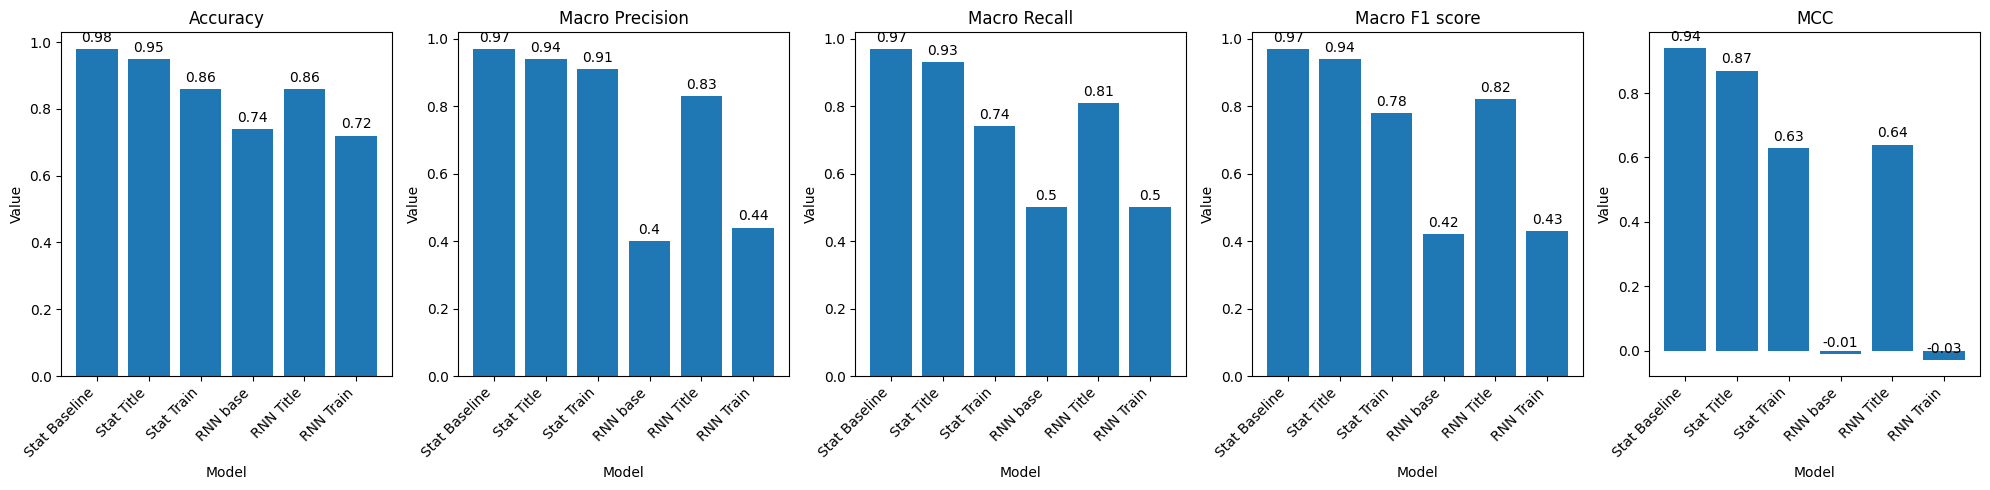

In [ ]:
# subplots for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(combined_df.columns), figsize=(20, 5))

for i, col in enumerate(combined_df.columns):
    ax = axes[i]
    bars = ax.bar(combined_df.index, combined_df[col])
    ax.set_title(col)
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

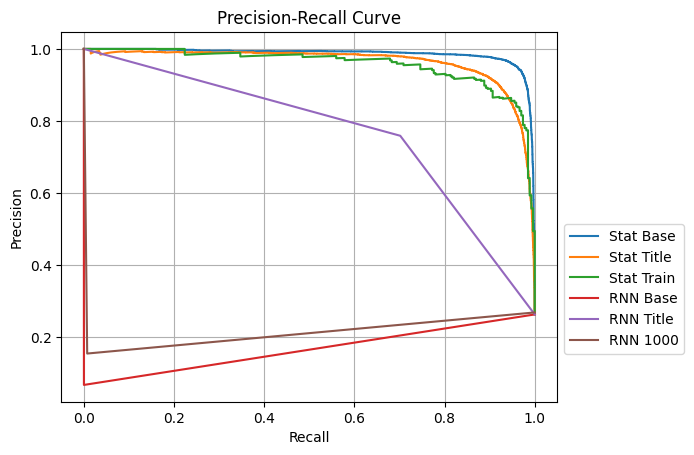

In [ ]:
pre_recall = {
    'recall': [stat_base_recall, stat_title_recall, stat_train_recall,
               rnn_base_recall, rnn_title_recall, rnn_1000_recall],
    'precision': [stat_base_precision, stat_title_precision, stat_train_precision,
                  rnn_base_precision, rnn_title_precision, rnn_1000_precision],
    'label': ['Stat Base', 'Stat Title', 'Stat Train',
              'RNN Base', 'RNN Title', 'RNN 1000']
}

pre_recall_df = pd.DataFrame(pre_recall)

# Plot Precision-Recall Curves
for i, row in pre_recall_df.iterrows():
    plt.plot(row['recall'], row['precision'], label=row['label'])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(bbox_to_anchor=(1, 0.5)) # change position to avoid overlap
plt.grid(True)
plt.show()

In [ ]:
# imbalanced problem
print(df_test['ComputationalLinguistics'].value_counts())

ComputationalLinguistics
0    14068
1     5006
Name: count, dtype: int64


# Part 2: Topic Modelling

This part is to build topics to detect topics of documents. Similar to Part 1, there would be 2 variations of the base model to compare the performance of model:
1. Unigram only vs Unigram and Bigram
2. Different number of topics (10 vs 40)
3. Training size: first 1000 vs first 20000 articles.

Therefore there would be a total of 4 models generated: 10 topics with bigram, 40 topics without bigram using 1000 articles or 20000 articles as input.

Similar preprocess approach was adapted: tokenized using regular expression, lammetize and removed all English stopwords. Since this is topic modelling task, there are no labels and Abstract was used as the input. To minimise typing error, the training process is defined in a class `LDAModel`.


In [ ]:
# import lib for part 2
# pre-processing
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

#!pip install pyLDAvis==3.4.1
import pyLDAvis.gensim
#!pip3 install gensim
from gensim.models import Phrases

from gensim.corpora import Dictionary

from gensim.models import LdaModel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.5 MB/s eta 0:00:00


In [ ]:
print(trainAbs[0][0:500])

  Reinforcement learning algorithms rely on carefully engineering environment
rewards that are extrinsic to the agent. However, annotating each environment
with hand-designed, dense rewards is not scalable, motivating the need for
developing reward functions that are intrinsic to the agent. Curiosity is a
type of intrinsic reward function which uses prediction error as reward signal.
In this paper: (a) We perform the first large-scale study of purely
curiosity-driven learning, i.e. without any e


In [ ]:
# tokenizer, lemmatizer, and stop words
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# from previous part
def preprocess_text(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text.lower())

    # remove stop words, only no, one chr only word
    # and lemmatize the remaining tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and not token.isnumeric() and len(token) > 1]
    return tokens


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Tokenization for Unigram and Bigram

In [ ]:
art1000 = trainAbs[:1000]
art20000 = trainAbs[:20000]
print(len(art1000), len(art20000))

1000 20000


In [ ]:
tok_1000 = [preprocess_text(abstract) for abstract in art1000]
tok_20000 = [preprocess_text(abstract) for abstract in art20000]
print(tok_1000[:10])

[['reinforcement', 'learning', 'algorithm', 'rely', 'carefully', 'engineering', 'environment', 'reward', 'extrinsic', 'agent', 'however', 'annotating', 'environment', 'hand', 'designed', 'dense', 'reward', 'scalable', 'motivating', 'need', 'developing', 'reward', 'function', 'intrinsic', 'agent', 'curiosity', 'type', 'intrinsic', 'reward', 'function', 'us', 'prediction', 'error', 'reward', 'signal', 'paper', 'perform', 'first', 'large', 'scale', 'study', 'purely', 'curiosity', 'driven', 'learning', 'without', 'extrinsic', 'reward', 'across', 'standard', 'benchmark', 'environment', 'including', 'atari', 'game', 'suite', 'result', 'show', 'surprisingly', 'good', 'performance', 'high', 'degree', 'alignment', 'intrinsic', 'curiosity', 'objective', 'hand', 'designed', 'extrinsic', 'reward', 'many', 'game', 'environment', 'investigate', 'effect', 'using', 'different', 'feature', 'space', 'computing', 'prediction', 'error', 'show', 'random', 'feature', 'sufficient', 'many', 'popular', 'rl', '

In [ ]:
# gen bigram (only ones that appear 20 times or more)
bi1000 = Phrases(tok_1000, min_count=20)
tok_bi1000 = [bi1000[abstract] for abstract in tok_1000]

bi20000 = Phrases(tok_20000, min_count=20)
tok_bi20000 = [bi20000[abstract] for abstract in tok_20000]

In [ ]:
tok_bi1000[2][:10]

['biomedical',
 'language',
 'understanding',
 'benchmark',
 'driving',
 'force',
 'artificial',
 'intelligence',
 'application',
 'large_language']

## 1000 aricles
A dictionary represent all words appeared in first 1000 documents using the unigram and bigram gerenated. A corpus was also created as a list from the first 1000 documents.

In [ ]:
# a dictionary representation of the documents.
dict_uni1000 = Dictionary(tok_1000)

# remove words w occur. less than 20 documents, or more than 50% of the documents.
dict_uni1000.filter_extremes(no_below=20, no_above=0.5)

temp = dict_uni1000[0]
corpus_uni1000 = [dict_uni1000.doc2bow(doc) for doc in tok_1000]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
temp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'across'

In [ ]:
class LDAModel:
    def __init__(self, corpus, dict_obj, chunksize=2000, passes=20, iterations=400, eval_every=None, random_seed=None):
        self.corpus = corpus
        self.dict_obj = dict_obj
        self.chunksize = chunksize
        self.passes = passes
        self.iterations = iterations
        self.eval_every = eval_every
        self.model = None
        self.random_seed = random_seed

    def train(self, num_topics, model_name=None):
        self.model = LdaModel(
            corpus=self.corpus,
        id2word=self.dict_obj.id2token,
        chunksize=self.chunksize,
        alpha='auto',
        eta='auto',
        iterations=self.iterations,
        num_topics=num_topics,
        passes=self.passes,
        eval_every=self.eval_every
        )
        if model_name:
            outputfile = f'{model_name}.gensim'
            print("Saving model in " + outputfile)
            print("")
            self.model.save(outputfile)
        return self.model, self.corpus, self.dict_obj

    def train_bigram(self, num_topics, model_name=None):
        self.model = LdaModel(corpus=self.corpus,
            id2word=self.dict_obj,
            chunksize=self.chunksize,
            alpha='auto',
            eta='auto',
            iterations=self.iterations,
            num_topics=num_topics,
            passes=self.passes,
            eval_every=self.eval_every
        )
        if model_name:
            outputfile = f'{model_name}.gensim'
            print("Saving model in " + outputfile)
            print("")
            self.model.save(outputfile)
        return self.model, self.corpus, self.dict_obj

    def print_top_topics(self):
        top_topics = self.model.top_topics(self.corpus)
        avg_topic_coherence = sum([t[1] for t in top_topics]) / self.model.num_topics
        print('Average topic coherence: %.4f.' % avg_topic_coherence)
        for topic in top_topics:
            print(f"Topic {topic[0]}: {topic[1]}")

        self.model.print_topics(num_words=20)

    def visualize(self):
        return pyLDAvis.gensim.prepare(self.model, self.corpus, self.dict_obj, sort_topics=False)



### 10 topics w/ bigram

In [ ]:
dict_bi1000 = Dictionary(tok_bi1000)
dict_bi1000.filter_extremes(no_below=20, no_above=0.5)
temp = dict_bi1000[0]
corpus_bi1000 = [dict_bi1000.doc2bow(doc) for doc in tok_bi1000]
temp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'across'

In [ ]:
# 10 topics using bigram
lda = LDAModel(corpus_bi1000, dict_bi1000, random_seed = 2)
model, corpus, dictionary = lda.train_bigram(10, model_name='model10_bi1000')
lda.print_top_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model10_bi1000.gensim

Average topic coherence: -1.9431.
Topic [(0.018886697, 'training'), (0.015650649, 'approach'), (0.015566249, 'data'), (0.014645746, 'language'), (0.0113592055, 'based'), (0.010295065, 'translation'), (0.009353753, 'system'), (0.0092007, 'task'), (0.009102436, 'network'), (0.00904877, 'source'), (0.008855056, 'performance'), (0.00822061, 'using'), (0.0074426616, 'accuracy'), (0.0072067096, 'human'), (0.007144413, 'new'), (0.0069088833, 'user'), (0.006761751, 'learning'), (0.00671522, 'study'), (0.006432636, 'use'), (0.006340877, 'architecture')]: -1.6578193551966625
Topic [(0.03212473, 'image'), (0.028208751, 'object'), (0.025286311, '3d'), (0.016716123, 'video'), (0.01443758, 'scene'), (0.0105093755, 'human'), (0.008282855, 'dataset'), (0.008260549, 'depth'), (0.007778631, '2d'), (0.0077380748, 'based'), (0.007535528, 'novel'), (0.0074926657, 'camera'), (0.0073293387, 'tracking'), (0.007217757, 'approach'), (0.0070901485, 'using'), (0.0069413637, 

In [ ]:
pyLDAvis.display(lda.visualize())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 40 topics w/o bigram

In [ ]:
# 10 topics using bigram
lda = LDAModel(corpus_uni1000, dict_uni1000, random_seed = 12)
model, corpus, dictionary = lda.train_bigram(40, model_name='model40_uni1000')
lda.print_top_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model40_uni1000.gensim

Average topic coherence: -2.1224.
Topic [(0.03901651, 'task'), (0.022384223, 'speech'), (0.01803397, 'image'), (0.013027749, 'detection'), (0.012925653, 'question'), (0.010190145, 'result'), (0.010107592, 'interaction'), (0.010044728, 'information'), (0.009709459, 'trained'), (0.0094182445, 'based'), (0.008948177, 'art'), (0.008848045, 'dataset'), (0.008774636, 'state'), (0.008438643, 'performance'), (0.008137448, 'show'), (0.008080617, 'two'), (0.007959991, 'paper'), (0.007842206, 'quality'), (0.0075384392, 'system'), (0.0074207694, 'approach')]: -1.327445860486866
Topic [(0.07016065, 'video'), (0.025331745, 'frame'), (0.02473048, 'action'), (0.018285803, 'temporal'), (0.011723449, 'performance'), (0.011432088, 'label'), (0.010387804, 'attention'), (0.009963556, 'sequence'), (0.009677865, 'propose'), (0.008996524, 'two'), (0.008052391, 'dataset'), (0.007945954, 'global'), (0.007836984, 'experiment'), (0.00774712, 'task'), (0.0075329887, 'dataset

In [ ]:
pyLDAvis.display(lda.visualize())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 20000 articles
Same process of building models were repeated but using more articles to build the dictionary and corpus.

In [ ]:
## 20000 article# Create a dictionary representation of the documents.
dict_uni20000 = Dictionary(tok_20000)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dict_uni20000.filter_extremes(no_below=20, no_above=0.5)
temp = dict_uni20000[0]
corpus_uni20000 = [dict_uni20000.doc2bow(doc) for doc in tok_20000]

print('Number of unique tokens: %d' % len(dict_uni20000))
print('Number of documents: %d' % len(corpus_uni20000))
temp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens: 5661
Number of documents: 20000


'across'

#### 10 topics w/ bigram

In [ ]:
dict_bi20000 = Dictionary(tok_bi20000)
dict_bi20000.filter_extremes(no_below=20, no_above=0.5)
corpus_bi20000 = [dict_bi20000.doc2bow(doc) for doc in tok_bi20000]
temp = dict_bi20000[0]
temp


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'across'

In [ ]:
lda = LDAModel(corpus_bi20000, dict_bi20000, random_seed = 4)
model, corpus, dictionary = lda.train_bigram(10, model_name='model10_bi20000')
lda.print_top_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model10_bi20000.gensim

Average topic coherence: -2.1145.
Topic [(0.022239402, 'training'), (0.02212067, 'method'), (0.021482116, 'data'), (0.018216653, 'learning'), (0.017852616, 'task'), (0.010514123, 'datasets'), (0.0102885375, 'domain'), (0.009143678, 'approach'), (0.00898814, 'sample'), (0.008775511, 'performance'), (0.008500364, 'image'), (0.00835306, 'label'), (0.007749893, 'class'), (0.0064375023, 'representation'), (0.0059584314, 'classification'), (0.0056675607, 'framework'), (0.005200769, 'distribution'), (0.0051703714, 'new'), (0.0050956076, 'problem'), (0.0050799795, 'however')]: -1.6373584054586259
Topic [(0.012446671, 'based'), (0.010467749, 'system'), (0.010262806, 'using'), (0.007995602, 'method'), (0.007732042, 'approach'), (0.007652324, 'data'), (0.007394408, 'different'), (0.0071381605, 'used'), (0.0061074817, 'result'), (0.005948485, 'performance'), (0.0059042475, 'use'), (0.0055039693, 'paper'), (0.0054023126, 'feature'), (0.0053714663, 'also'), (0

In [ ]:
pyLDAvis.display(lda.visualize())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 40 topics w/o bigram

In [ ]:
lda = LDAModel(corpus_uni20000, dict_uni20000, random_seed = 32)
model, corpus, dictionary = lda.train(40, model_name='model40_uni20000')
lda.print_top_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model40_uni20000.gensim

Average topic coherence: -3.5622.
Topic [(0.05669359, 'feature'), (0.032471575, 'method'), (0.025147716, 'information'), (0.02009613, 'proposed'), (0.017332248, 'multi'), (0.01674148, 'propose'), (0.016340397, 'based'), (0.014147827, 'module'), (0.014139833, 'attention'), (0.013483315, 'two'), (0.013243738, 'art'), (0.012995729, 'state'), (0.012344992, 'level'), (0.011354934, 'performance'), (0.010829956, 'experiment'), (0.010581212, 'local'), (0.009451422, 'novel'), (0.009318493, 'different'), (0.00900664, 'paper'), (0.008968239, 'result')]: -1.2329316012836287
Topic [(0.03861575, 'learning'), (0.035683032, 'training'), (0.0348262, 'data'), (0.0270454, 'method'), (0.016785722, 'label'), (0.016532607, 'supervised'), (0.015834466, 'datasets'), (0.015617939, 'class'), (0.014914508, 'task'), (0.014707582, 'performance'), (0.0131493695, 'sample'), (0.011422786, 'classification'), (0.010670373, 'propose'), (0.010368776, 'approach'), (0.008983729, 'da

In [ ]:
pyLDAvis.display(lda.visualize())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
